In [1]:
import finmag
from finmag.energies import Exchange, DMI, Zeeman, Demag
from finmag.util.consts import mu0
import matplotlib.pyplot as plt
import os
import scipy
import mshr
import gc
import scipy.integrate
import dolfin as df
import numpy as np

[2019-01-23 20:21:49] INFO: Finmag logging output will be appended to file: '/home/rp20g15/.finmag/global.log'
[2019-01-23 20:21:49] DEBUG: Building modules in 'native'...
[2019-01-23 20:21:49] DEBUG: FinMag          92a61445736016f1d3eba420ba3d05659e52035a
[2019-01-23 20:21:49] DEBUG: Dolfin          2017.1.0             Matplotlib      2.2.3               
[2019-01-23 20:21:49] DEBUG: Numpy           1.15.4               Scipy           0.17.0              
[2019-01-23 20:21:49] DEBUG: IPython         5.7.0                Python          2.7.12              
[2019-01-23 20:21:49] WARNING: Could not determine version of paraview using dpkg.
[2019-01-23 20:21:49] WARNING: The package paraview is probably not installed.
[2019-01-23 20:21:49] DEBUG: Paraview        None                 Sundials        2.5.0               
[2019-01-23 20:21:49] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 16.04.3 LTS  
[2019-01-23 20:21:49] DEBUG: Registering debug signal handler. Pr

In Finmag, we have lots of pre-made meshes which you can use for simple geometric shapes. These are located in the finmag.util.meshes module and include:
* box
* cylinder
* ellipsoid
* elliptic_cylinder
* elliptic_nanodisk
* nanodisk
* regular_polygon
* regular_polygon_extruded
* sphere
* truncated_cone

Meshes created from these functions can be directly used with Finmag without any problems. For more complex structures, you can use programmes such as Netgen or Gmsh directly and then convert to the Dolfin XML mesh format. Dolfin is the underlying Finite Element library which Finmag is built on.

*Remember, the bigger the mesh, the longer simulations will take! The demagnetising field in particular is proportional to $M^{4/3}$, where $M$ is the number of surface nodes.*

Here, we'll just create a small nanodisk mesh:

In [6]:
d = 40 # diameter (nm)
t = 10 # thickness (nm)
h = 3 # Discretisation length (nm)
mesh = finmag.util.meshes.nanodisk(d, t, 3, save_result=False)

[2019-01-23 20:27:27] DEBUG: Using netgen to convert /tmp/tmpb7kfjF.geo to DIFFPACK format.
[2019-01-23 20:27:27] DEBUG: Done!
[2019-01-23 20:27:27] DEBUG: Using dolfin-convert to convert /tmp/tmpb7kfjF.grid to xml format.
[2019-01-23 20:27:28] DEBUG: Compressing /tmp/tmpb7kfjF.xml
[2019-01-23 20:27:28] DEBUG: Removing file '/tmp/tmpb7kfjF.xml.gz' because mesh is created on the fly.
[2019-01-23 20:27:28] DEBUG: Removing file '/tmp/tmpb7kfjF.geo' because mesh is created on the fly.


We now create a simulation object. This basically comes in a few steps:

* Create a sim (finmag.Simulation or finmag.NormalModeSimulation)
* Set properties (Ms, the initial magnetisation, the damping constant, etc).
* Add energy terms (Exchange, DMI, Zeeman, Demagnetising field, etc).

Then, we normally relax the system to find a metastable state (i.e. where the magnetisation is not changing).

Finally, we may then go on to evolve the system further, perhaps after adding a new energy or changing the applied field - (sim.run_until)

Alternatively, we might compute properties around the metastable state - for e.g. the normal modes (sim.compute_normal_modes, if finmag.NormalModeSimulation was used).

Here, we'll just relax the system:

In [7]:
B = 0
alpha = 1.0
Ms = 384e3
A = 8.78e-12
D = 1.58e-3

sim = finmag.Simulation(mesh, Ms, unit_length=1e-9)

def m_init(pos):
    x, y, z = pos
    if x**2 + y**2 <= (d/2) ** 2:
        return (0, 0, 1)
    else:
        return (0, 0, -1)

sim.set_m(m_init)

sim.add(Exchange(A))
sim.add(DMI(D))
sim.add(Demag())

if B != 0:
    sim.add(Zeeman((0, 0, B*1e-3/mu0)))

sim.relax(stopping_dmdt=0.1)

[2019-01-23 20:28:27] INFO: Finmag logging output will be written to file: '/home/rp20g15/eigenmodes-fd-test/submission-scripts/unnamed.log' (any old content will be overwritten).
[2019-01-23 20:28:27] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2019-01-23 20:28:27] INFO: Creating Sim object name='unnamed', instance_id=0 (rank=0/1).
[2019-01-23 20:28:27] DEBUG:    Total number of Sim objects in this session: 1
[2019-01-23 20:28:27] INFO: <Mesh of topological dimension 3 (tetrahedra) with 594 vertices and 2134 cells, ordered>
/usr/local/lib/python2.7/dist-packages/aeon/timer.py:35: UserWarning: You are nesting measurements in __init__::LLG.
  warnings.warn("You are nesting measurements in {}::{}.".format(name, group))
[2019-01-23 20:28:27] DEBUG: Creating LLG object.
[2019-01-23 20:28:27] DEBUG: Creating Exchange object with method box-matrix-petsc, in Jacobian.
[2019-01-23 20:28:27] DEBUG: Adding interaction Exchange to simulation.
[2019-01-23 20:28:27] DEBUG: Creating DMI objec

[2019-01-23 20:28:35] DEBUG: At t=6.2e-13, last_dmdt=4.97e+06 * stopping_dmdt, next dt=1e-14.
[2019-01-23 20:28:35] DEBUG: At t=6.3e-13, last_dmdt=5.02e+06 * stopping_dmdt, next dt=1e-14.
[2019-01-23 20:28:35] DEBUG: At t=6.4e-13, last_dmdt=5.06e+06 * stopping_dmdt, next dt=1e-14.
[2019-01-23 20:28:35] DEBUG: At t=6.5e-13, last_dmdt=5.09e+06 * stopping_dmdt, next dt=1e-14.
[2019-01-23 20:28:35] DEBUG: At t=6.6e-13, last_dmdt=5.11e+06 * stopping_dmdt, next dt=1e-14.
[2019-01-23 20:28:35] DEBUG: At t=6.7e-13, last_dmdt=5.12e+06 * stopping_dmdt, next dt=1e-14.
[2019-01-23 20:28:35] DEBUG: At t=6.8e-13, last_dmdt=5.12e+06 * stopping_dmdt, next dt=1e-14.
[2019-01-23 20:28:35] DEBUG: At t=6.9e-13, last_dmdt=5.12e+06 * stopping_dmdt, next dt=1e-14.
[2019-01-23 20:28:36] DEBUG: At t=7.05e-13, last_dmdt=5.09e+06 * stopping_dmdt, next dt=1.5e-14.
[2019-01-23 20:28:36] DEBUG: At t=7.27e-13, last_dmdt=5.02e+06 * stopping_dmdt, next dt=2.25e-14.
[2019-01-23 20:28:36] DEBUG: At t=7.61e-13, last_dmdt

We can save a VTK file which can be plotted using Paraview or alternative plotting systems:

In [9]:
sim.save_vtk('test_new_vtk.pvd', overwrite=True)

[2019-01-23 20:36:44] WARNING: Removing file 'test_new_vtk.pvd' and all associated .vtu files (because overwrite=True).
[2019-01-23 20:36:44] DEBUG: Saved field at t=1.22511482928e-09 to file 'test_new_vtk.pvd' (snapshot #0; saving took 0.0127 seconds).


Alternatively, we can create a function which uses Matplotlib to plot the simulation results.

In [10]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

def plot_m(sim, component='x', filename=None, figsize=(20, 10), extent=[-40, 40, -40, 40],
           z=5.0, gridpoints=[100, 100], cbar=True, ncbarticks=5, cmap='RdBu'):
    
    components = ['x', 'y', 'z']
    
    x = np.linspace(extent[0], extent[1], gridpoints[0])
    y = np.linspace(extent[2], extent[3], gridpoints[1])
    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()
    Z = np.zeros_like(X) + z

    mx = []
    my = []
    mz = []

    for xv, yv, zv in zip(X, Y, Z):
        try:
            mxv, myv, mzv = sim.llg.m_field.f(xv, yv, zv)
        except:
            mxv, myv, mzv = 0.0, 0.0, 0.0

        mx.append(mxv)
        my.append(myv)
        mz.append(mzv)

    mx = np.array(mx).reshape(gridpoints[0], gridpoints[1])
    my = np.array(my).reshape(gridpoints[0], gridpoints[1])
    mz = np.array(mz).reshape(gridpoints[0], gridpoints[1])
    
    m = [mx, my, mz]
    
    if component in ['x', 'y', 'z']:
        fig = plt.figure(figsize=(figsize[0]/3, figsize[1]))

        grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,1),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
        
    elif component == 'all':
        fig = plt.figure(figsize=figsize)
        grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
    
    if component in components:
        ax = grid[0]
        im = ax.imshow(m[components.index(component)], origin='lower', 
                       extent=extent, vmin=-1.0, vmax=1.0, cmap=cmap)
        ax.set_title('$m_{}$'.format(component))
        ax.set_xlabel('$x$ (nm)')
        ax.set_ylabel('$y$ (nm)')

    elif component == 'all':
        for ax, comp, label in zip(grid, [mx, my, mz], ['x', 'y', 'z']):
            im = ax.imshow(comp, origin='lower', extent=extent,
                           vmin=-1.0, vmax=1.0, cmap=cmap)
            ax.set_title('$m_{}$'.format(label))
            ax.set_xlabel('$x$ (nm)')
            ax.set_ylabel('$y$ (nm)')
        
    else:
        raise ValueError("Component is not valid")

    if cbar==True:
        ax.cax.colorbar(im, ticks=np.linspace(-1, 1, ncbarticks))
        ax.cax.toggle_label(True)

    if filename:
        fig.savefig(filename, dpi=600)
        
    

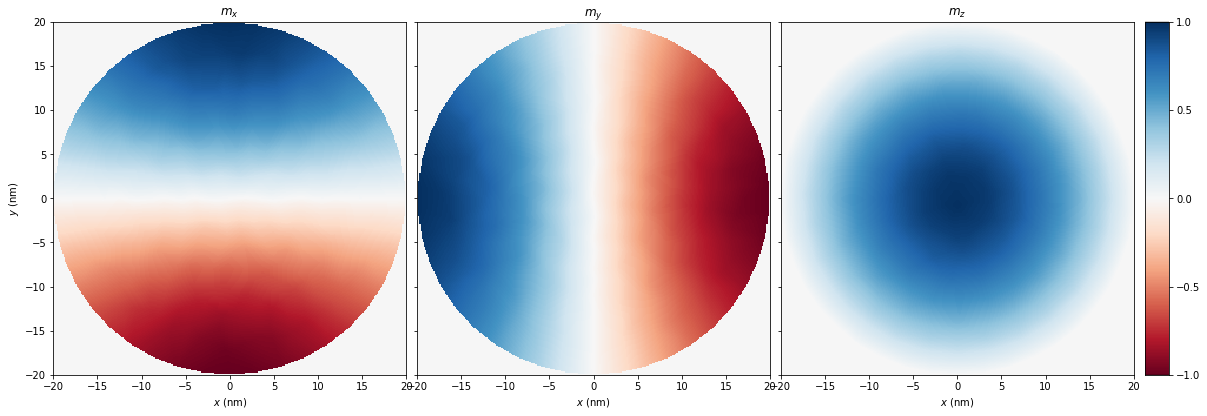

In [13]:
plot_m(sim, component='all', filename='vortex.pdf', extent=[-20, 20, -20, 20], z=5.0,
       gridpoints=[300, 300], cmap='RdBu')

If running multiple Finmag simulations in a single Python session, it's important to shutdown the simulation objects, as sometimes things stay in memory. To do this:

In [14]:
sim.shutdown()
gc.collect()

[2019-01-23 20:38:00] INFO: Shutting down Simulation object finmag.Simulation(name='unnamed', instance_id=0) with <Mesh of topological dimension 3 (tetrahedra) with 594 vertices and 2134 cells, ordered>
[2019-01-23 20:38:00] DEBUG: 0 other Simulation instances alive.
[2019-01-23 20:38:00] DEBUG:    shutdown(): 1-refcount 5 for unnamed
[2019-01-23 20:38:00] DEBUG: 'Deletinging all get methods in TableWriter(name=unnamed.ndt)
[2019-01-23 20:38:00] DEBUG: 'Deleting' get method for H_Demag in TableWriter(name=unnamed.ndt)
[2019-01-23 20:38:00] DEBUG: 'Deleting' get method for dmdt in TableWriter(name=unnamed.ndt)
[2019-01-23 20:38:00] DEBUG: 'Deleting' get method for E_total in TableWriter(name=unnamed.ndt)
[2019-01-23 20:38:00] DEBUG: 'Deleting' get method for H_Exchange in TableWriter(name=unnamed.ndt)
[2019-01-23 20:38:00] DEBUG: 'Deleting' get method for m in TableWriter(name=unnamed.ndt)
[2019-01-23 20:38:00] DEBUG: 'Deleting' get method for steps in TableWriter(name=unnamed.ndt)
[201

10687